### **Transfer Learning**

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

2025-07-20 00:25:08.973801: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-20 00:25:08.974785: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 00:25:08.980982: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-20 00:25:08.991866: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752989109.006253    1284 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752989109.01

In [2]:
data_dir = 'agri_crops/Agricultural-crops'
image_size = (300, 300)
batch_size = 16

train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

validation_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    color_mode="rgb",
    image_size=image_size,
    batch_size=batch_size,
    seed=42
)

# Define augmentation as a Sequential layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.1),
    layers.GaussianNoise(0.02),
], name="data_augmentation")

# Extract class names
class_names = train_ds.class_names

# Apply 'data_augmentation' to the training images
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls = tf.data.AUTOTUNE,
)

# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.prefetch(tf.data.AUTOTUNE)

Found 759 files belonging to 30 classes.
Using 608 files for training.
Found 759 files belonging to 30 classes.
Using 151 files for validation.


2025-07-20 00:25:12.124483: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### **EfficientNetB3**

In [3]:
def make_efficientnet_model(input_shape, num_classes):
    backbone = keras.applications.EfficientNetB3(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    backbone.trainable = False  # Freeze base initially

    inputs = keras.Input(shape=input_shape)
    x = keras.applications.efficientnet.preprocess_input(inputs)
    x = backbone(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs, name="efficientnetb3_model")

In [4]:
model_effnet = make_efficientnet_model(input_shape=(300, 300, 3), num_classes=30)

model_effnet.compile(
    optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)

callbacks = [
    keras.callbacks.ModelCheckpoint("efficientnetb3_baseline_best.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6)
]

history_effnet = model_effnet.fit(
    train_ds,
    epochs=60,
    validation_data=validation_ds,
    callbacks=callbacks,
)

Epoch 1/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step - acc: 0.0491 - loss: 4.2772 - val_acc: 0.3576 - val_loss: 2.9819 - learning_rate: 3.0000e-04
Epoch 2/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - acc: 0.2395 - loss: 2.8300 - val_acc: 0.5033 - val_loss: 2.5461 - learning_rate: 3.0000e-04
Epoch 3/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - acc: 0.4281 - loss: 2.0798 - val_acc: 0.5828 - val_loss: 2.1269 - learning_rate: 3.0000e-04
Epoch 4/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - acc: 0.5313 - loss: 1.6850 - val_acc: 0.6093 - val_loss: 1.7721 - learning_rate: 3.0000e-04
Epoch 5/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - acc: 0.5501 - loss: 1.5207 - val_acc: 0.6755 - val_loss: 1.4882 - learning_rate: 3.0000e-04
Epoch 6/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - acc: 0.5872 - loss: 1.3826 - val_acc: 0.7020 - val_loss: 1.2555 - learning_rate: 3.0000e-04
Epoch 7/60
38/38 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - acc: 0.6588 - loss: 1.2091 - val_acc: 0.7152 - val_loss: 1.0893 - learning_rate: 3.0

### **Accuracy vs Validation Plot**

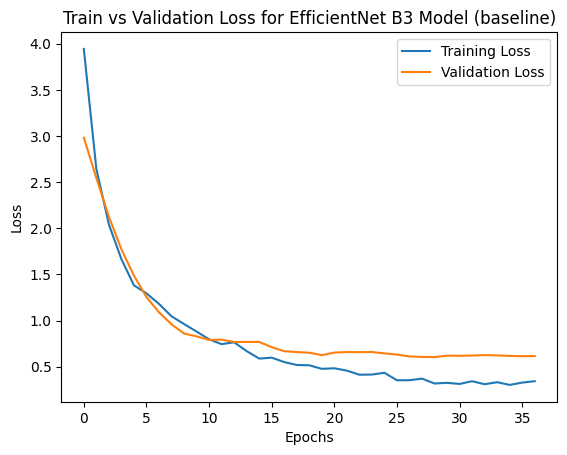

In [5]:
plt.plot(range(len(history_effnet.history["loss"])), history_effnet.history["loss"], label="Training Loss")
plt.plot(range(len(history_effnet.history["val_loss"])), history_effnet.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss for EfficientNet B3 Model (baseline)")
plt.legend()
plt.show()

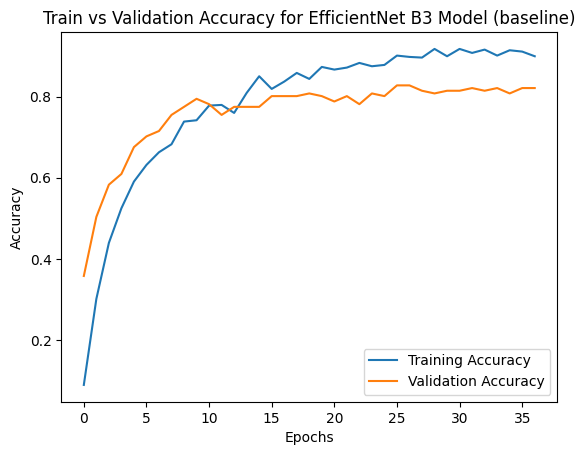

In [6]:
plt.plot(range(len(history_effnet.history["acc"])), history_effnet.history["acc"], label="Training Accuracy")
plt.plot(range(len(history_effnet.history["val_acc"])), history_effnet.history["val_acc"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy for EfficientNet B3 Model (baseline)")
plt.legend()
plt.show()

### **Classification Report**

In [11]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    labels=list(range(len(class_names))),
    target_names=class_names,
    zero_division=0
))


                     precision    recall  f1-score   support

             Cherry       0.62      0.71      0.67         7
       Coffee-plant       0.80      0.57      0.67         7
           Cucumber       0.75      1.00      0.86         6
   Fox_nut(Makhana)       1.00      0.57      0.73         7
              Lemon       1.00      1.00      1.00         5
         Olive-tree       0.60      0.75      0.67         4
Pearl_millet(bajra)       0.75      0.86      0.80         7
      Tobacco-plant       0.67      1.00      0.80         6
             almond       0.75      0.75      0.75         4
             banana       1.00      0.60      0.75         5
           cardamom       0.75      1.00      0.86         3
             chilli       1.00      0.67      0.80         3
              clove       1.00      0.80      0.89         5
            coconut       1.00      1.00      1.00         1
             cotton       0.80      0.89      0.84         9
               gram    